In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib.patches as mpatches

import pyemma.msm as msm
import pyemma.coordinates as coor
import msmtools.generation as msmgen

from sklearn.decomposition import PCA
from numpy import linalg as LA
from scipy.linalg import eigh

In [2]:
def draw_arrow(a, v, color):
    plt.arrow(0, 0, a*v[0], a*v[1], color=color, width=0.02, linewidth=3,  head_width=0.08, head_length=1)

Given a time series $\{x_t \}_{t=1,2,...,N}$, denoted as $\mathbf{X_t} $. We construct a mean free data series:

\begin{align}
\delta \mathbf{X_t}  =  \mathbf{X_t} - \mathbb{E}[\mathbf{X_t}]_t
\end{align}

This can be written as a correlation
\begin{align}
c_{ij}(\tau) = \mathbb{E} [ x_i(t)x_j(t+τ)]
\end{align}

Shown as a sum one obtains:

\begin{align}
c_{ij}(\tau)=\frac{1}{N-\tau-1}\sum_{t=1}^{N-\tau}x_{i}(t)\, x_{j}(t+\tau).
\end{align}
given as the time-lagged covariance. 

Now consider the time-lagged matrices $\delta \mathbf{X_t^{(+\tau)}}$ and $\delta \mathbf{X_t^{(-\tau)}}$ one obtains:

\begin{align}
\mathbf{C}_d(\tau)= \frac{1}{N-\tau-1} \delta \mathbf{X_t^{(+\tau)}} \cdot \delta (\mathbf{X_t^{(-\tau)}})^T
\end{align}

In addition one constructs the standard covariance matrix:

\begin{align}
\mathbf{C}(0)= \frac{1}{N-1} \delta \mathbf{X_t} \cdot \delta (\mathbf{X_t})^T
\end{align}

Now one needs to symmetrize the time-lagged covariance as follows:

\begin{align}
\mathbf{C}(\tau)=\frac{1}{2}\left(\mathbf{C}_{d}(\tau)+\mathbf{C}_{d}^{\top}(\tau)\right)
\end{align}

This leads to the generalized eigenvalue problem as follows:

\begin{align}
\mathbf{C}(\tau)\:\mathbf{U}=\mathbf{C}(0)\:\mathbf{U}\:\boldsymbol{\Lambda}
\end{align}

In [3]:
def tICA(x, tau = 10):
    
    ''' 
    Computes the time independent components of the input data.
    
        Parameters: 
                x: np.darray(d, N) 
                Array of data points.
                
              tau: int 
                Lag time.
              
            
        Returns:
                V: npdarray(d,d) of time independent components 
                
             vals: np.darray(d,d) eigenvalues associated with components
              
     '''
    x_mean_free = (x -x.mean(axis=1, keepdims=True))
    
    unlagged = x_mean_free[:,:-tau] # end short
    lagged = x_mean_free[:,tau:] # start late
    
    C_0 = (1/(x_mean_free.shape[1]-1))*(x_mean_free@x_mean_free.T)
    C_T = (1/(unlagged.shape[1]-1- tau))*(unlagged@lagged.T)
    
    C_T_symm = 0.5*(C_T + C_T.T)
    
    vals, V = eigh(C_T_symm, C_0, eigvals_only=False)
    
    return vals, V

### Random 2D-Gaussian

In [4]:
g_x = np.random.normal(0,1, size = 1000)
g_y = np.random.normal(0,8, size = 1000)
g_coor = np.vstack((g_x,g_y)) 
g_mean_free = (g_coor -g_coor.mean(axis=1, keepdims=True))

In [5]:
vals, V = tICA(g_coor)

In [6]:
pca = PCA(n_components=2)
pca.fit(g_mean_free.T)

pc = pca.components_
sv = pca.explained_variance_

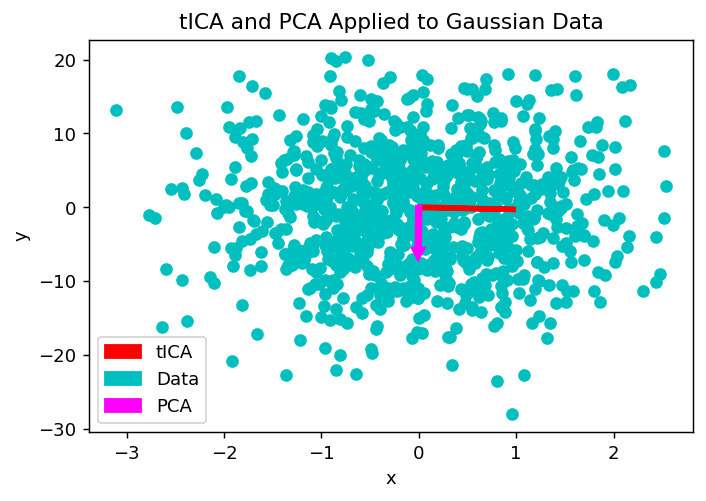

In [7]:
fig, ax = plt.subplots(dpi = 130)

ax.scatter(g_coor.T[:,0], g_coor.T[:,1], color = 'c')
draw_arrow(5*vals[1], V[:,1], color='red')
draw_arrow(0.09*sv[0], pc[:,0], color='magenta')
ax.set_title('tICA and PCA Applied to Gaussian Data')
ax.set_xlabel('x')
ax.set_ylabel('y')
red_patch = mpatches.Patch(color='red', label='tICA')
magenta_patch = mpatches.Patch(color='magenta', label='PCA')
blue_patch = mpatches.Patch(color='c', label='Data')

plt.legend(handles=[red_patch, blue_patch, magenta_patch])
plt.show()

### 2D Double Well 

In [2]:
def Pot(X,Y):
      
    return -20*(np.exp(-((X/20)**2 + ((Y-1.2))**2)) + np.exp(-((X/20)**2 +((Y+1.2))**2)))

<IPython.core.display.Javascript object>


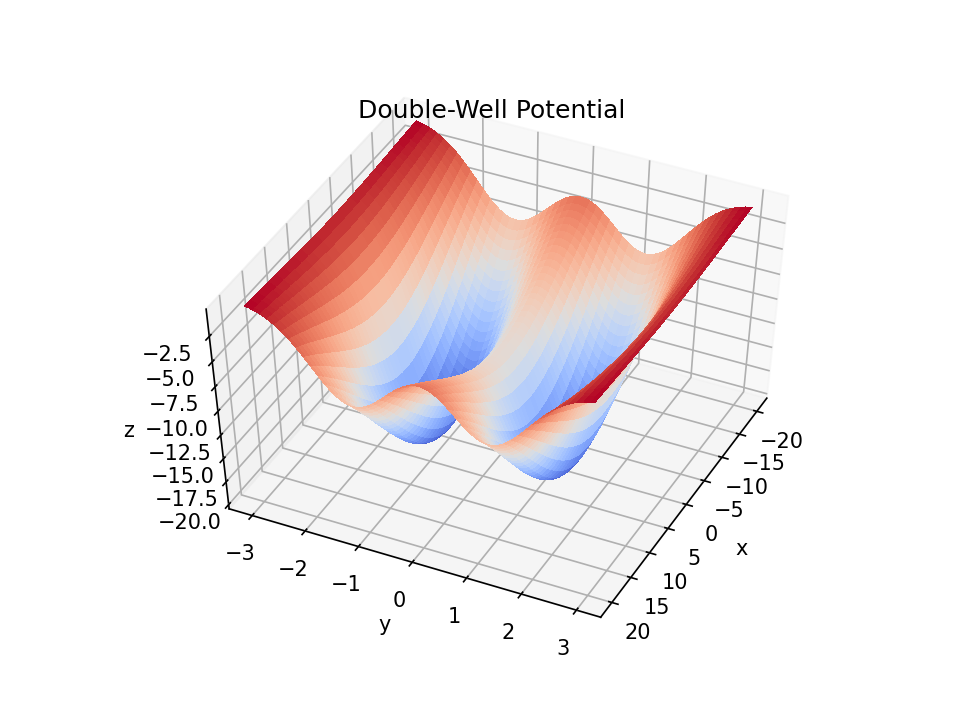

In [6]:
x = np.linspace(-20,20,100)
y = np.linspace(-3,3,100)
X,Y = np.meshgrid(x,y)

%matplotlib notebook
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.set_title('Double-Well Potential')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
 
ax.plot_surface(X, Y, Pot(X,Y), cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

In [11]:
N = 100000
vec = np.zeros((2,N))
init = np.ones(2).T
vec[:,0] = init 
for i in range(1,N):
    
    current = vec[:,i-1]
    proposed = current + np.random.uniform(-1,1, size = 2)
    #print(proposed[0])
    dE = Pot(proposed[0], proposed[1])-Pot(current[0], current[1])
    temp = np.exp(-dE)
    A = min(1,temp)
    r = np.random.uniform(0,1)
    #print(A)
    if A > r:
        vec[:,i] = proposed
    else:
        vec[:,i] = current

In [12]:
vec_mean_free = (vec -vec.mean(axis=1, keepdims=True))

pca = PCA(n_components=2)
pca.fit(vec.T)

pc = pca.components_
sv = pca.explained_variance_

vals, V = tICA(vec)

<IPython.core.display.Javascript object>


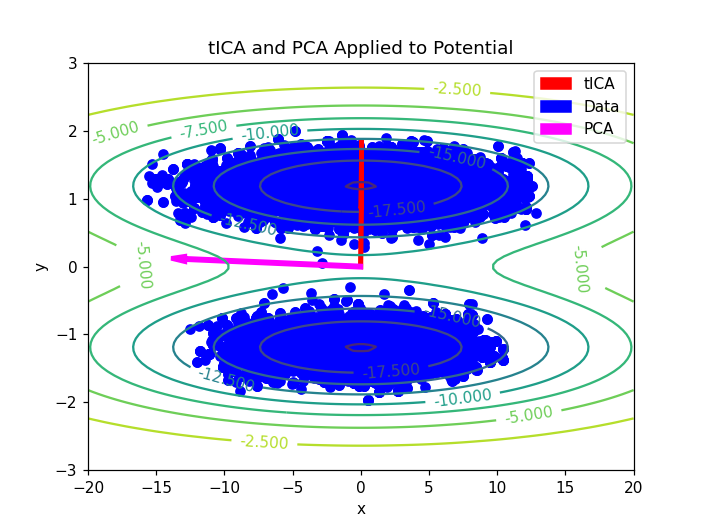

In [13]:
fig, ax = plt.subplots()
CS = ax.contour(X, Y, Pot(X,Y))
ax.scatter(vec[0,:], vec[1,:], color = 'blue')
draw_arrow(vals[1], V[:,1], color='red')
draw_arrow(sv[0], pc[:,0], color='magenta')
ax.clabel(CS, inline=1, fontsize=10)
ax.set_title('tICA and PCA Applied to Potential')
ax.set_xlabel('x')
ax.set_ylabel('y')
red_patch = mpatches.Patch(color='red', label='tICA')
magenta_patch = mpatches.Patch(color='magenta', label='PCA')
blue_patch = mpatches.Patch(color='blue', label='Data')

plt.legend(handles=[red_patch, blue_patch, magenta_patch])
plt.show()


### PyEmma

In [5]:
P = np.array([[0.99, 0.01],
              [0.01, 0.99]])
T = 1000
means = [np.array([-1,1]), np.array([1,-1])]
widths = [np.array([0.3,2]),np.array([0.3,2])]

In [6]:
# continuous trajectory
X = np.zeros((T, 2))
# hidden trajectory
dtraj = msmgen.generate_traj(P, T)
for t in range(T):
    s = dtraj[t]
    X[t,0] = widths[s][0] * np.random.randn() + means[s][0]
    X[t,1] = widths[s][1] * np.random.randn() + means[s][1]    

In [23]:
pca = coor.pca(data = X)
pc = pca.eigenvectors
S = pca.eigenvalues

tica = coor.tica(data = X)

ic = tica.eigenvectors
L = tica.eigenvalues

<IPython.core.display.Javascript object>


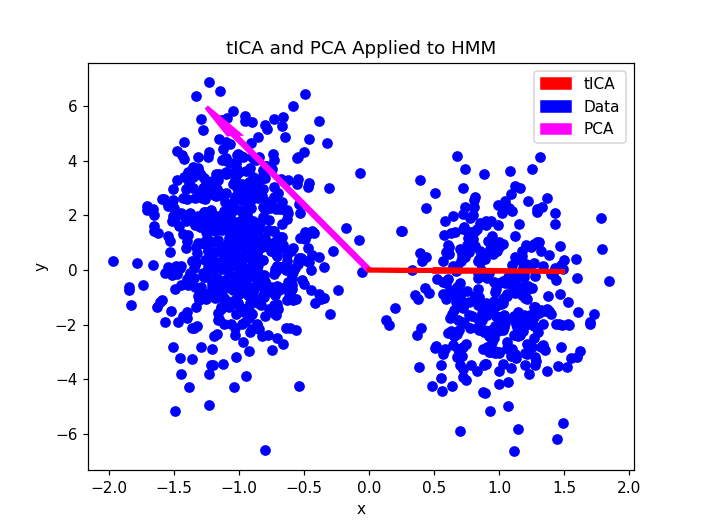

In [24]:
fig, ax = plt.subplots()
ax.scatter(X[:,0], X[:,1], color = 'blue')
draw_arrow(S[0], pc[:,0], color='magenta')
draw_arrow(L[0], ic[:,0], color='red')
ax.set_title('tICA and PCA Applied to HMM')
ax.set_xlabel('x')
ax.set_ylabel('y')
red_patch = mpatches.Patch(color='red', label='tICA')
magenta_patch = mpatches.Patch(color='magenta', label='PCA')
blue_patch = mpatches.Patch(color='blue', label='Data')
plt.legend(handles=[red_patch, blue_patch, magenta_patch])
